In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

/Users/quangnguyen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Load Data

In [2]:
def load_data(train_path, test_path):
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data

In [3]:
raw_data = pd.read_csv(
    os.path.join('..', '..', 'data', 'raw', 'Credit Card Transactions Fraud Detection Dataset 2019.csv'))
raw_data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
data = raw_data.copy(deep=True)
data = data.drop(['Unnamed: 0'], axis=1)
data['full_name'] = data['first'] + ' ' + data['last']
data = data.drop(['first', 'last'], axis=1)
data = data.drop(['trans_date_trans_time'], axis=1)
data['dob'] = pd.to_datetime(data['dob'])
data['dob'] = (pd.to_datetime(data['dob']) - data['dob'].min()) // pd.Timedelta('1s')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1296675 non-null  int64  
 1   merchant    1296675 non-null  object 
 2   category    1296675 non-null  object 
 3   amt         1296675 non-null  float64
 4   gender      1296675 non-null  object 
 5   street      1296675 non-null  object 
 6   city        1296675 non-null  object 
 7   state       1296675 non-null  object 
 8   zip         1296675 non-null  int64  
 9   lat         1296675 non-null  float64
 10  long        1296675 non-null  float64
 11  city_pop    1296675 non-null  int64  
 12  job         1296675 non-null  object 
 13  dob         1296675 non-null  int64  
 14  trans_num   1296675 non-null  object 
 15  unix_time   1296675 non-null  int64  
 16  merch_lat   1296675 non-null  float64
 17  merch_long  1296675 non-null  float64
 18  is_fraud    1296675 no

In [7]:
data.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,full_name
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1999382400,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,Jennifer Banks
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1692748800,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,Stephanie Gill
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1174608000,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,Edward Sanchez
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1331769600,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,Jeremy White
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1937865600,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,Tyler Garcia


In [8]:
def extract_date_features(date_str):
    try:
        year, month, day = map(int, date_str.split('-'))
        return pd.Series({'birth_year': year, 'birth_month': month, 'birth_day': day})
    except:
        return pd.Series({'birth_year': np.nan, 'birth_month': np.nan, 'birth_day': np.nan})

## Feature Engineering


In [9]:
def engineer_features(data):
    output_feature = data['is_fraud']
    
    # Extract date features from 'dob'
    dob_features = data['dob'].apply(extract_date_features)
    data = pd.concat([data, dob_features], axis=1)
    
    num_features = ['unix_time', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop', 'birth_year', 'birth_month', 'birth_day']
    cat_features = ['cc_num', 'merchant', 'category', 'gender', 'street', 'city', 'state', 'zip', 'job']
    
    # Encode categorical features
    for feature in cat_features:
        data[feature] = data[feature].astype('category').cat.codes
    
    # Select all features
    input_features = data[num_features + cat_features]
    
    # Convert all to numeric, replacing any non-numeric values with NaN
    input_features = input_features.apply(pd.to_numeric, errors='coerce')
    
    # Fill NaN values with mean of the column
    input_features = input_features.fillna(input_features.mean())
    
    return input_features, output_feature

## Model

In [10]:
def prepare_data(train_data, test_data):
    # Engineer features
    X_train, y_train = engineer_features(train_data)
    X_test, y_test = engineer_features(test_data)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape for LSTM [samples, time steps, features]
    X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    
    return X_train_reshaped, y_train, X_test_reshaped, y_test

In [11]:
# Function to create the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# Train the model
def train_model(model, X_train, y_train, epochs=10, batch_size=32):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_split=0.2, verbose=1)
    return model, history

In [13]:
def evaluate_model(model, X_test, y_test):
    # Predict probabilities
    y_pred = model.predict(X_test)
    
    # Convert probabilities to class predictions
    y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
    
    # Convert y_test to a 1D numpy array if it's a Pandas Series
    y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)
    y_test = y_test.flatten()  # Ensure y_test is 1D
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

## Plot


In [14]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Run the pipeline

X_train shape: (1296675, 1, 19)
X_test shape: (555719, 1, 19)
Epoch 1/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step - accuracy: 0.9941 - loss: 0.0306 - val_accuracy: 0.9955 - val_loss: 0.0176
Epoch 2/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.9957 - loss: 0.0166 - val_accuracy: 0.9957 - val_loss: 0.0159
Epoch 3/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.9959 - loss: 0.0150 - val_accuracy: 0.9958 - val_loss: 0.0144
Epoch 4/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.9961 - loss: 0.0137 - val_accuracy: 0.9964 - val_loss: 0.0130
Epoch 5/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step - accuracy: 0.9963 - loss: 0.0129 - val_accuracy: 0.9965 - val_loss: 0.0128
Epoch 6/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9964 - val_loss: 0.0126
Epoch 7/10
32417/32417 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step - accuracy: 0.9964 - loss: 0.0123 - val_accuracy: 0.9964 - val_loss: 0.0125
Epoch 8

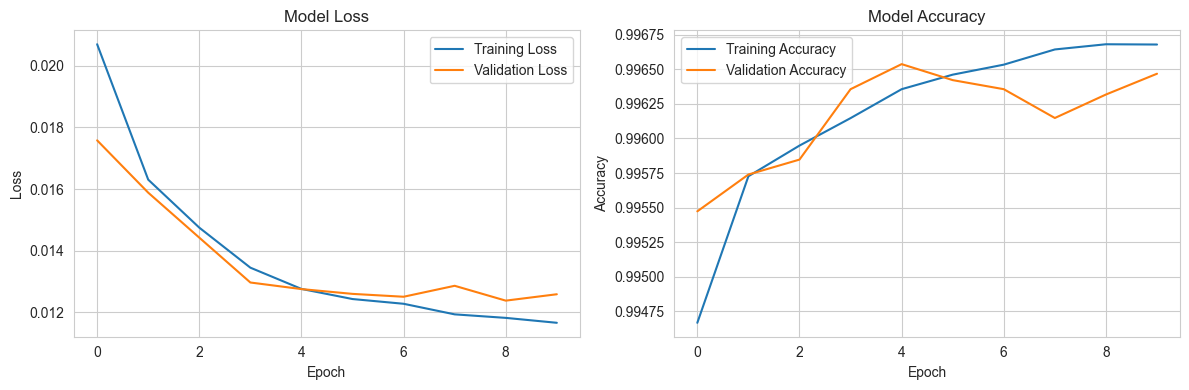

In [15]:
if __name__ == '__main__':
    train_path = '/Users/quangnguyen/PycharmProjects/MLDA-Datathon-2024/fraudTrain.csv'
    test_path = '/Users/quangnguyen/PycharmProjects/MLDA-Datathon-2024/fraudTest.csv'
    
    # Load and prepare data
    train_data, test_data = load_data(train_path, test_path)
    X_train, y_train, X_test, y_test = prepare_data(train_data, test_data)
    
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    
    # Create and train model
    input_shape = (X_train.shape[1], X_train.shape[2])  # This should be (1, 19)
    model = create_lstm_model(input_shape)
    
    trained_model, history = train_model(model, X_train, y_train, epochs=10, batch_size=32)
    
    # Evaluate model
    evaluate_model(trained_model, X_test, y_test)
    
    # Plot training history
    plot_training_history(history)